## 均值方差测试
>以 2018-01-02 (2018年 第一个交易日)为例，在2017年累计收益差距明显的10个股票，以2017年全年的累积收益作为股票的预期年化收益，不添加约束条件，ReturnRiskRatio 梯度上升，以ReturnRiskRatio为横坐标，个股权重为纵坐标，展示变化图。

In [1]:
import pandas as  pd
import numpy as np
# from backtest import *
from optimizer_1 import *
from functools import reduce

In [2]:
all_stocks_lists = pd.read_pickle("stocks_pool/all_stocks_list.pkl")
date = "2018-01-02"
return_ratio = np.arange(0.01,1,0.01)
returnRiskRatio = [(r,1-r) for r in return_ratio]

In [3]:
stocks_lists = all_stocks_lists['2018-01-02']
close_price = get_price(stocks_lists,"2017-01-01","2018-01-01",fields="close")
sort_chg = close_price.apply(lambda x:x[-1]/x[0]-1).sort_values().dropna()


## 均值方差

In [ ]:
sort_chg1 = sort_chg[sort_chg>0]
order_book_ids = sort_chg1[::int(len(sort_chg1)/9)].index.tolist()
annualized_returns = sort_chg[order_book_ids]

all_results = {}
for r in returnRiskRatio:
    results = portfolio_optimize(order_book_ids,date,method=OptimizeMethod.MEAN_VARIANCE,annualized_return=annualized_returns,returnRiskRatio=r)
    all_results[r] = results


In [16]:
weights = pd.DataFrame(pd.DataFrame(all_results).iloc[0].to_dict()).T

In [20]:
weights = weights.set_index(weights.index.get_level_values(0)/weights.index.get_level_values(1))

In [84]:
weights.to_pickle("mean_variance_weights.pkl")

** 波动率最小化 **

In [25]:
min_volatility_results = portfolio_optimize(order_book_ids,date,method=OptimizeMethod.VOLATILITY_MINIMIZATION)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.09752079242277291
            Iterations: 11
            Function evaluations: 11
            Gradient evaluations: 11


** 预期收益最大化 **

In [26]:
max_expected_returns_results = portfolio_optimize(order_book_ids,date,method=OptimizeMethod.RETURN_MAXIMIZATION,annualized_return=annualized_returns)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.449971390425321
            Iterations: 3
            Function evaluations: 36
            Gradient evaluations: 3


In [31]:
covMat = close_price.pct_change().iloc[-126:][order_book_ids].cov()

In [33]:
volatility = close_price.pct_change().iloc[-126:][order_book_ids].std()

In [73]:
x = min_volatility_results[0]
mcr = get_marginal_contribution2risk(x,covMat)
ctr = get_contribution2risk(x,covMat)
pcr = get_percentile_contribution2risk(x,covMat)
vol_min_results = pd.DataFrame({"波动率最小化-MCR":mcr,"波动率最小化-CTR":ctr,"波动率最小化-PCR":pcr})

In [74]:
x = pd.Series(1,index=order_book_ids)/len(order_book_ids)
mcr = get_marginal_contribution2risk(x,covMat)
ctr = get_contribution2risk(x,covMat)
pcr = get_percentile_contribution2risk(x,covMat)
equal_weights_results = pd.DataFrame({"等权-MCR":mcr,"等权-CTR":ctr,"等权-PCR":pcr})

In [63]:
MCR = {k:get_marginal_contribution2risk(v,covMat) for k,v in weights.iterrows()}
CTR = {k:get_contribution2risk(v,covMat) for k,v in weights.iterrows()}
PCR = {k:get_percentile_contribution2risk(v,covMat) for k,v in weights.iterrows()}

In [56]:
def get_marginal_contribution2risk(x,covMat):
    portfolio_volatility = np.sqrt(np.dot(x,np.dot(x,covMat)))
    return pd.Series(np.dot(covMat,x)/portfolio_volatility,index=x.index)
    
def get_contribution2risk(x,covMat):
    mcr = get_marginal_contribution2risk(x,covMat)
    return np.multiply(x,mcr)

def get_percentile_contribution2risk(x,covMat):
    ctr = get_contribution2risk(x,covMat)
    portfolio_volatility = np.sqrt(np.dot(x,np.dot(x,covMat)))
    return ctr/portfolio_volatility
    

In [94]:
pd.DataFrame(MCR).to_pickle("MCR.pkl")
pd.DataFrame(CTR).to_pickle("CTR.pkl")
pd.DataFrame(PCR).to_pickle("PCR.pkl")

In [92]:
pd.concat([vol_min_results,equal_weights_results,volatility,annualized_returns],axis=1).rename(columns={0:"波动率"}).to_pickle("plot-数据1.pkl")

In [90]:
annualized_returns.name = "预期收益"

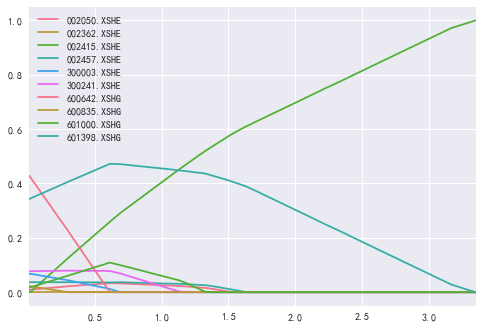

In [100]:
weights[:3.5].plot()

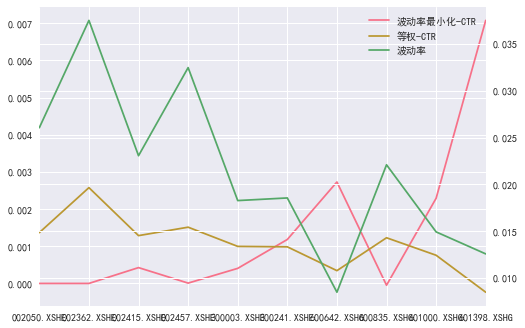

In [130]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
fig,ax = plt.subplots()
plot_data = pd.read_pickle("测试结果数据/plot-数据1.pkl")[['波动率最小化-CTR',"等权-CTR","波动率"]]
plot_data.iloc[:,:2].plot(ax=ax)
handles1 = ax.get_legend_handles_labels()
ax.legend("")
ax = ax.twinx()
plot_data[['波动率']].plot(ax=ax,c="g")
# ax.legend(loc="upper center",bbox_to_anchor=(0.445,0.9))
handles2 = ax.get_legend_handles_labels()
ax.set_xticklabels(labels=plot_data.index,rotation=90)
plt.legend(handles1[0]+handles2[0],handles1[1]+handles2[1])

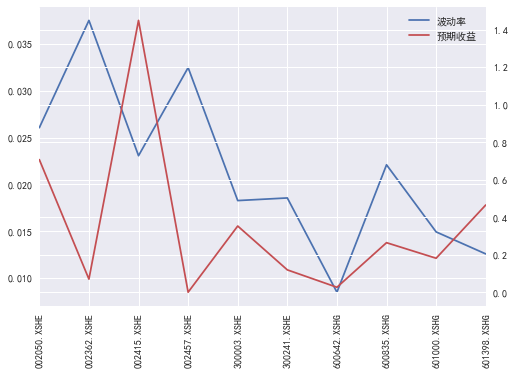

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
fig,ax = plt.subplots()
plot_data = pd.read_pickle("测试结果数据/plot-数据1.pkl")[['波动率','预期收益']]
plot_data['波动率'].plot(ax=ax,color='b')
ax.set_xticklabels(labels=plot_data.index,rotation=90)

handles1 = ax.get_legend_handles_labels()
ax =ax.twinx()
plot_data['预期收益'].plot(ax=ax,color='r')
handles2 = ax.get_legend_handles_labels()
plt.legend(handles1[0]+handles2[0],handles1[1]+handles2[1])
